# ✅ Typical Flow in LangGraph

### 1. Define State
- Decide what information your graph will carry 

---

### 2. Define Nodes
- Each node is just a Python function that takes `state` as input and returns updates to the state.

---

### 3. Add Nodes to Workflow
- Use `workflow.add_node("name", fn)` to register nodes in the graph.

---

### 4. Add Edges (Transitions)
- Define how execution flows between nodes.
- Use `workflow.add_edge("nodeA", "nodeB")` or conditional edges.
- Add `START → first node` and `last node → END`.

---

### 5. Compile the Graph
- Convert `StateGraph` to a runnable graph:
  ```python
  app = workflow.compile()

---
### 6. Invoke / Run the Graph
- result = app.invoke(inputs)

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

# Define the state that will flow through the graph
class State(TypedDict):
    name: str
    greeting: str
    farewell: str

# Node 1: greet the user
def greeter(state: State):
    return {"greeting": f"Hello {state['name']}! 👋"}

# Node 2: say goodbye
def farwell(state: State):
    return {"farewell": f"Goodbye {state['name']}! 👋"}

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("greeter", greeter)
workflow.add_node("farwell", farwell)

# Add edges (flow of execution)
workflow.add_edge(START, "greeter")
workflow.add_edge("greeter", "farwell")
workflow.add_edge("farwell", END)

# Compile the workflow into an app
app = workflow.compile()

# Run with input
result = app.invoke({"name": "DHS 2025"})
print(result)


{'name': 'DHS 2025', 'greeting': 'Hello DHS 2025! 👋', 'farewell': 'Goodbye DHS 2025! 👋'}


## Order bot

In [2]:
from typing import TypedDict, Optional

class AgentState(TypedDict):
    input: str
    output: Optional[str]
    


In [3]:
def take_order_node(state: AgentState) -> AgentState:
    print("📝 [Take Order Node] Processing input...")
    user_input = state["input"]
    order = f"Order received: {user_input}"
    return {"input": user_input, "output": order}

def confirm_order_node(state: AgentState) -> AgentState:
    print(f"✅ [Confirm Node] Confirming: {state['output']}")
    confirmation = f"{state['output']} - Confirmed!"
    return {"input": state["input"], "output": confirmation}

def thank_you_node(state: AgentState) -> AgentState:
    print("🙏 [Thank You Node] Wrapping up...")
    final_message = f"{state['output']} Thank you for your order!"
    return {"input": state["input"], "output": final_message}


In [4]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

# Add nodes
graph.add_node("take_order", take_order_node)
graph.add_node("confirm_order", confirm_order_node)
graph.add_node("thank_you", thank_you_node)

# Define flow
graph.set_entry_point("take_order")
graph.add_edge("take_order", "confirm_order")
graph.add_edge("confirm_order", "thank_you")
graph.add_edge("thank_you", END)

# Compile the graph
app = graph.compile()


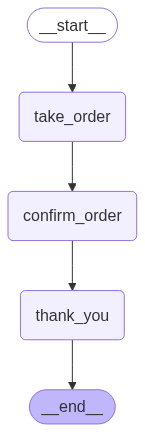

In [5]:
from IPython.display import Markdown, display, Image

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [6]:
result = app.invoke({"input": " Ice cream"})
print("🏁 Final Result:", result)


📝 [Take Order Node] Processing input...
✅ [Confirm Node] Confirming: Order received:  Ice cream
🙏 [Thank You Node] Wrapping up...
🏁 Final Result: {'input': ' Ice cream', 'output': 'Order received:  Ice cream - Confirmed! Thank you for your order!'}


# Coffee Bot: Sugar or No Sugar

In [7]:
from typing import TypedDict, Optional

class AgentState(TypedDict):
    input: str
    output: Optional[str]


In [8]:
def decision_node(state: AgentState) -> AgentState:
    user_input = state["input"].lower()
    if "sugar" in user_input:
        print("☕ Decision: User wants sugar.")
        return {"input": state["input"], "output": None, "next": "with_sugar"}
    else:
        print("☕ Decision: User wants no sugar.")
        return {"input": state["input"], "output": None, "next": "no_sugar"}

def with_sugar_node(state: AgentState) -> AgentState:
    return {
        "input": state["input"],
        "output": "Serving coffee with sugar!",
        "next": None
    }

def no_sugar_node(state: AgentState) -> AgentState:
    return {
        "input": state["input"],
        "output": "Serving black coffee!",
        "next": None
    }


In [9]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("decide", decision_node)
graph.add_node("with_sugar", with_sugar_node)
graph.add_node("no_sugar", no_sugar_node)

graph.set_entry_point("decide")

# Conditional routing based on state["next"]
graph.add_conditional_edges(
    "decide",
    lambda state: state["next"],
    {
        "with_sugar": "with_sugar",
        "no_sugar": "no_sugar"
    }
)

# End the graph after either path
graph.add_edge("with_sugar", END)
graph.add_edge("no_sugar", END)

# Compile
app = graph.compile()


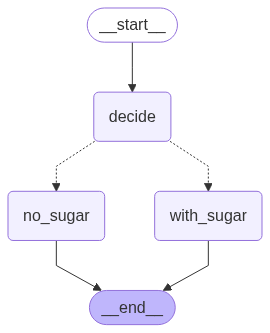

In [10]:
from IPython.display import Markdown, display, Image

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [11]:
print("\n--- Sugar Example ---")
app.invoke({"input": "I want coffee with sugar"})




--- Sugar Example ---
☕ Decision: User wants sugar.


{'input': 'I want coffee with sugar', 'output': 'Serving coffee with sugar!'}

In [12]:
print("\n--- No Sugar Example ---")
print(app.invoke({"input": "Just a black coffee"}))


--- No Sugar Example ---
☕ Decision: User wants no sugar.
{'input': 'Just a black coffee', 'output': 'Serving black coffee!'}
